In [1]:
# STEP 1 (uten å endre kolonnenavn): Les inn CSV uten å miste første algoritmekolonne (f.eks. "A*")
import pandas as pd
import numpy as np
from pathlib import Path

FILES = {
    10: "results_elevation_weight_1_1.csv",
    25: "results_elevation_weight_1_25.csv",
    50: "results_elevation_weight_1_5.csv",
}

def _looks_like_pure_index(series: pd.Series) -> bool:
    """Sjekk om en kolonne er en ren løpeindeks (0..N-1 eller 1..N)."""
    if not pd.api.types.is_numeric_dtype(series):
        return False
    vals = series.to_numpy()
    n = len(vals)
    return np.array_equal(vals, np.arange(n)) or np.array_equal(vals, np.arange(1, n+1))

def load_wide_csv(path: Path) -> pd.DataFrame:
    # Les ALT først (ikke bruk index_col=0, så vi ikke mister første algoritme-kolonne som kan være "A*")
    dfw = pd.read_csv(path)

    # Hvis første kolonne er en "Unnamed" / "index" / ren løpeindeks → dropp den
    first = dfw.columns[0]
    if first.lower().startswith("unnamed") or first.lower() in {"index", "idx"} or _looks_like_pure_index(dfw[first]):
        dfw = dfw.drop(columns=[first], errors="ignore")

    # Tving verdier til numerisk; behold kolonnenavnene uendret
    for c in dfw.columns:
        dfw[c] = pd.to_numeric(dfw[c], errors="coerce")

    # Dropp helt tomme kolonner/rader, reset index
    dfw = dfw.dropna(axis=1, how="all").dropna(axis=0, how="all").reset_index(drop=True)
    return dfw

# Les alle tre filer til "wide" og bygg "df" i long-format (beholder kolonnenavn uendret)
wide = {}
long_rows = []
for pct, fname in FILES.items():
    p = Path(fname)
    assert p.exists(), f"Finner ikke filen: {p}"
    dfw = load_wide_csv(p)
    wide[pct] = dfw

    dfl = (
        dfw.reset_index(names="test")
           .melt(id_vars="test", var_name="algorithm", value_name="path_length")
           .dropna(subset=["path_length"])
    )
    dfl["elevation_pct"] = pct
    long_rows.append(dfl)

df = pd.concat(long_rows, ignore_index=True)

# Rask sjekk (uten å endre kolonnenavn)
algs_by_weight = {pct: sorted(dfw.columns.tolist()) for pct, dfw in wide.items()}
print("Algoritmer per vekt:")
for pct, algs in algs_by_weight.items():
    print(f"  {pct}%: {algs}")

print("\nFinnes 'A*' i kolonnene?:",
      {pct: ("A*" in cols) for pct, cols in algs_by_weight.items()})

print("\nEksempel head (10%):")
display(wide[10].head())

print("\nLong-format (første 10 rader):")
display(df.head(10))


Algoritmer per vekt:
  10%: ['a_star', 'd_star_lite', 'dijkstra', 'gbfs', 'informed_rrt', 'jps', 'lazy_theta_star', 'lpa_star', 'rrt', 'rrt_connect', 'rrt_star', 's_theta_star', 'theta_star']
  25%: ['a_star', 'd_star_lite', 'dijkstra', 'gbfs', 'informed_rrt', 'jps', 'lazy_theta_star', 'lpa_star', 'rrt', 'rrt_connect', 'rrt_star', 's_theta_star', 'theta_star']
  50%: ['a_star', 'd_star_lite', 'dijkstra', 'gbfs', 'informed_rrt', 'jps', 'lazy_theta_star', 'lpa_star', 'rrt', 'rrt_connect', 'rrt_star', 's_theta_star', 'theta_star']

Finnes 'A*' i kolonnene?: {10: False, 25: False, 50: False}

Eksempel head (10%):


,a_star,dijkstra,d_star_lite,lpa_star,gbfs,jps,theta_star,rrt_star,lazy_theta_star,s_theta_star,informed_rrt,rrt,rrt_connect
0,1296.028316,1296.028316,1299.162972,1296.751268,1299.162972,1295.696435,1176.245342,1193.725877,1176.245342,1176.245342,1177.881914,1553.177171,1257.136218
1,3223.733084,3223.548362,2842.438774,2839.335747,2839.875113,2815.058614,2772.528604,2822.811715,2772.528604,2773.795706,2814.948546,3374.525171,2825.374196
2,2659.700341,2659.605712,2512.860113,2519.187673,2512.860113,2496.943949,2371.786916,2559.613580,2371.786916,2371.786916,2373.715024,3053.366683,2393.047457
3,3430.209332,3428.292038,3052.059309,3046.540479,3048.870399,3019.781017,2842.354409,2942.754294,2842.354409,2842.354409,2872.599726,3632.780401,2907.186622
4,2918.006781,2917.803088,2532.905619,2539.471457,2532.905619,2516.508041,2390.409145,2480.718556,2390.409145,2390.409145,2416.217383,2959.574499,2480.416934



Long-format (første 10 rader):


,test,algorithm,path_length,elevation_pct
0,0,a_star,1296.028316,10
1,1,a_star,3223.733084,10
2,2,a_star,2659.700341,10
3,3,a_star,3430.209332,10
4,4,a_star,2918.006781,10
5,5,a_star,3436.245734,10
6,6,a_star,3633.313066,10
7,7,a_star,2787.496744,10
8,8,a_star,4736.317361,10
9,9,a_star,3701.723349,10


In [2]:
DROP_ALGS = {"jps", "gbfs", "d_star_lite", "lpa_star"}
df = df[~df["algorithm"].str.lower().isin(DROP_ALGS)].reset_index(drop=True)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   test           540 non-null    int64  
 1   algorithm      540 non-null    object 
 2   path_length    540 non-null    float64
 3   elevation_pct  540 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 17.0+ KB


In [24]:
# display the values for a_star algorithm

df[df["algorithm"] == "a_star"].head(60)



,test,algorithm,path_length,elevation_pct
0,0,a_star,1296.028316,10
1,1,a_star,3223.733084,10
2,2,a_star,2659.700341,10
3,3,a_star,3430.209332,10
4,4,a_star,2918.006781,10
5,5,a_star,3436.245734,10
6,6,a_star,3633.313066,10
7,7,a_star,2787.496744,10
8,8,a_star,4736.317361,10
9,9,a_star,3701.723349,10


In [5]:
# Tie-aware statistikk: unik seier (wins_unique) + delt 1.plass (wins_tie) + utvidet sammendrag
import numpy as np

TOL = dict(rtol=1e-9, atol=1e-9)

wins_tie_list = []
wins_unique_list = []
tie_info = {}

for pct in sorted(df["elevation_pct"].unique()):
    d = df[df["elevation_pct"] == pct].copy()

    # Min per test og hvem som matcher min (m/ toleranse)
    d["_min"] = d.groupby("test")["path_length"].transform("min")
    d["_is_win"] = np.isclose(d["path_length"], d["_min"], **TOL)

    # Tie-størrelse per test (hvor mange deler 1. plass)
    tie_size = d.groupby("test")["_is_win"].sum().rename("tie_size")
    d = d.join(tie_size, on="test")

    # Teller pr algoritme
    tie_counts_alg = d.groupby("algorithm")["_is_win"].sum().astype(int).rename("wins_tie")
    unique_counts_alg = (
        d.loc[d["_is_win"] & (d["tie_size"] == 1)]
         .groupby("algorithm")["_is_win"]
         .sum()
         .astype(int)
         .rename("wins_unique")
    )

    # Sikre samme indeks
    all_algs = sorted(d["algorithm"].unique())
    wins_tie_list.append(
        pd.DataFrame(
            {"algorithm": all_algs,
             "wins_tie": tie_counts_alg.reindex(all_algs, fill_value=0).values,
             "elevation_pct": pct}
        ).set_index(["elevation_pct", "algorithm"])
    )
    wins_unique_list.append(
        pd.DataFrame(
            {"algorithm": all_algs,
             "wins_unique": unique_counts_alg.reindex(all_algs, fill_value=0).values,
             "elevation_pct": pct}
        ).set_index(["elevation_pct", "algorithm"])
    )

    # Fordeling av tie-størrelser (1=unik vinner)
    tie_info[pct] = tie_size.value_counts().sort_index().to_dict()

wins_tie_df = pd.concat(wins_tie_list).sort_index()
wins_unique_df = pd.concat(wins_unique_list).sort_index()

# KJØR DETTE FØRST – lager 'summary' som basis for join og sort (utvidet med std, q25, q75, IQR)
g = df.groupby(["elevation_pct", "algorithm"])["path_length"]
summary = pd.DataFrame({
    "mean":   g.mean(),
    "median": g.median(),
    "std":    g.std(),
    "q25":    g.quantile(0.25),
    "q75":    g.quantile(0.75),
})
summary["IQR"] = summary["q75"] - summary["q25"]

# Slå inn i summary (dropp gammel wins* hvis finnes) + legg til 'wins' (= wins_tie)
summary = (
    summary.drop(columns=[c for c in ["wins_tie", "wins_unique", "wins"] if c in summary.columns])
           .join([wins_tie_df, wins_unique_df])
           .fillna({"wins_tie": 0, "wins_unique": 0})
           .astype({"wins_tie": "int64", "wins_unique": "int64"})
           .sort_index()
)
summary["wins"] = summary["wins_tie"].astype(int)

# Vis: sortér på wins_unique ↓, så wins_tie ↓, deretter median ↑, mean ↑
for pct in sorted(df["elevation_pct"].unique()):
    print(f"\n=== {pct}% elevation weight ===")
    # Eksempel: {1: 2, 2: 2, 3: 16} → 2 soleklare vinnere, 2 ganger delt mellom 2, 16 ganger delt mellom 3
    print("Tie-size distribution (tests per size):", tie_info[pct])
    display(
        summary.loc[pct]
               .sort_values(by=["wins_unique", "wins_tie", "median", "mean"],
                            ascending=[False, False, True, True])
               .round(3)
    )



=== 10% elevation weight ===
Tie-size distribution (tests per size): {1: 2, 2: 2, 3: 16}


,mean,median,std,q25,q75,IQR,wins_tie,wins_unique,wins
algorithm,,,,,,,,,
s_theta_star,2639.891,2677.597,779.644,2293.419,3122.279,828.860,18,2,18
lazy_theta_star,2639.840,2676.963,779.627,2293.493,3122.127,828.634,18,0,18
theta_star,2639.840,2676.963,779.627,2293.493,3122.127,828.634,18,0,18
informed_rrt,2655.147,2702.851,788.053,2297.938,3137.387,839.448,0,0,0
rrt_star,2689.075,2717.830,780.568,2350.184,3139.610,789.426,0,0,0
rrt_connect,2689.738,2718.844,790.805,2320.096,3169.239,849.144,0,0,0
dijkstra,3140.294,3279.359,943.456,2617.904,3650.543,1032.638,0,0,0
a_star,3140.769,3280.158,943.554,2617.975,3650.416,1032.440,0,0,0
rrt,3375.848,3503.653,919.427,2923.335,3923.225,999.890,0,0,0



=== 25% elevation weight ===
Tie-size distribution (tests per size): {1: 2, 2: 2, 3: 16}


,mean,median,std,q25,q75,IQR,wins_tie,wins_unique,wins
algorithm,,,,,,,,,
s_theta_star,2639.891,2677.597,779.644,2293.419,3122.279,828.860,18,2,18
lazy_theta_star,2639.840,2676.963,779.627,2293.493,3122.127,828.634,18,0,18
theta_star,2639.840,2676.963,779.627,2293.493,3122.127,828.634,18,0,18
rrt_connect,2681.839,2707.787,797.212,2319.155,3182.728,863.572,0,0,0
informed_rrt,2657.536,2708.153,787.802,2299.530,3135.183,835.653,0,0,0
rrt_star,2693.492,2730.070,762.070,2317.903,3144.186,826.284,0,0,0
dijkstra,3140.826,3280.041,943.920,2617.989,3650.766,1032.777,0,0,0
a_star,3140.859,3280.465,943.689,2618.467,3650.115,1031.648,0,0,0
rrt,3400.870,3507.322,878.367,2968.282,3961.637,993.355,0,0,0



=== 50% elevation weight ===
Tie-size distribution (tests per size): {1: 2, 2: 2, 3: 16}


,mean,median,std,q25,q75,IQR,wins_tie,wins_unique,wins
algorithm,,,,,,,,,
s_theta_star,2639.891,2677.597,779.644,2293.419,3122.279,828.860,18,2,18
lazy_theta_star,2639.840,2676.963,779.627,2293.493,3122.127,828.634,18,0,18
theta_star,2639.840,2676.963,779.627,2293.493,3122.127,828.634,18,0,18
rrt_connect,2691.895,2712.814,798.519,2335.870,3164.568,828.698,0,0,0
informed_rrt,2657.347,2726.447,789.882,2297.371,3136.600,839.229,0,0,0
rrt_star,2763.669,2905.829,791.320,2328.725,3294.033,965.308,0,0,0
dijkstra,3140.953,3279.546,943.823,2617.941,3650.585,1032.645,0,0,0
a_star,3141.136,3280.561,943.919,2618.483,3650.878,1032.395,0,0,0
rrt,3329.624,3419.255,825.299,2853.733,3923.624,1069.892,0,0,0


###
mean – gjennomsnittlig rutelengde over alle tester. (Lavere = bedre)

median – midtverdien (robust mot outliers). (Lavere = bedre)

std – standardavvik; hvor mye resultatene varierer. (Lavere = mer stabil)

q25 – 25-percentilen (nedre kvartil). 25 % av testene er kortere enn dette.

q75 – 75-percentilen (øvre kvartil). 75 % av testene er kortere enn dette.

IQR – interkvartilbredde = q75 − q25 (spredning i midterste 50 %). (Lavere = jevnere)

wins – hvor mange tester algoritmen var best på (lavest path length). (Høyere = oftere vinner)


1: 2 → I 2 tester var det én soleklar vinner (ingen uavgjort).

2: 2 → I 2 tester delte to algoritmer 1.-plassen (uavgjort mellom 2).

3: 16 → I 16 tester delte tre algoritmer 1.-plassen.

C:\Users\NecoD\AppData\Local\Temp\ipykernel_26580\1794658634.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=order, showfliers=False)


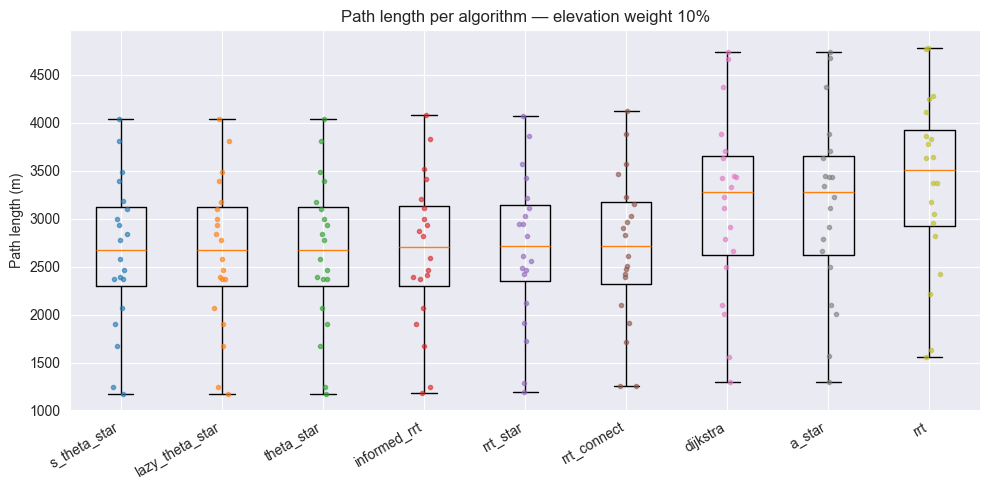

C:\Users\NecoD\AppData\Local\Temp\ipykernel_26580\1794658634.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=order, showfliers=False)


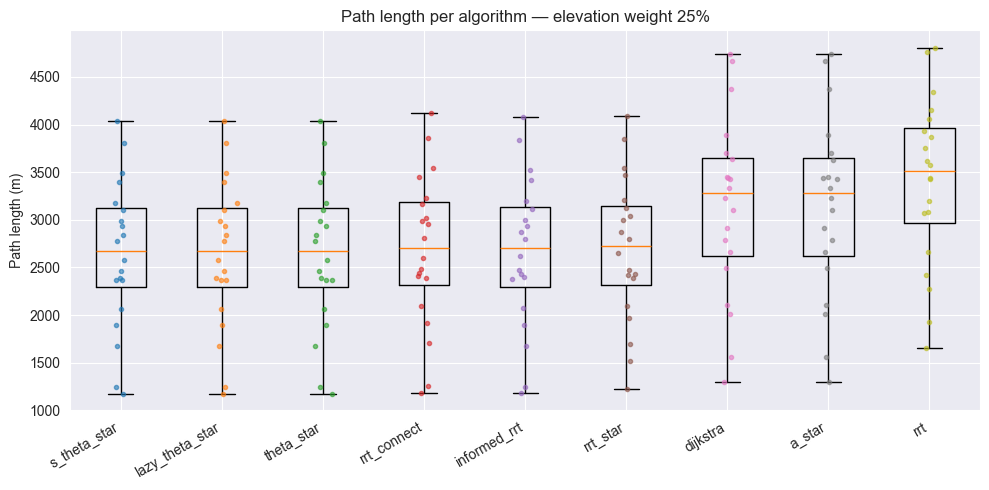

C:\Users\NecoD\AppData\Local\Temp\ipykernel_26580\1794658634.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=order, showfliers=False)


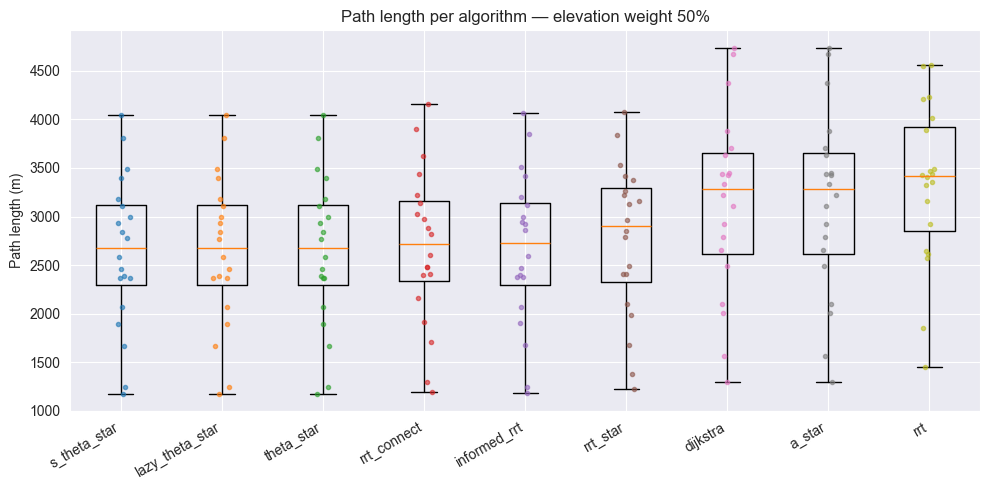

In [6]:
# Boxplot m/ punkter, sortert på wins_unique ↓, wins_tie ↓, median ↑, mean ↑
import numpy as np
import matplotlib.pyplot as plt

def order_algs_for_weight(pct, summary_df):
    sub = summary_df.loc[pct]
    keys = [("wins_unique", False), ("wins_tie", False), ("median", True), ("mean", True)]
    by = [k for k, _ in keys if k in sub.columns]
    asc = [a for k, a in keys if k in sub.columns]
    return sub.sort_values(by=by, ascending=asc).index.tolist()

np.random.seed(42)

for pct in sorted(df["elevation_pct"].unique()):
    order = order_algs_for_weight(pct, summary)
    d = df[df["elevation_pct"] == pct]
    data = [d.loc[d["algorithm"] == a, "path_length"].values for a in order]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.boxplot(data, labels=order, showfliers=False)

    # jitter av enkeltpunktene (20 tester per algoritme)
    for i, a in enumerate(order, start=1):
        y = d.loc[d["algorithm"] == a, "path_length"].values
        x = np.random.normal(i, 0.04, size=len(y))
        ax.plot(x, y, "o", alpha=0.6, markersize=3)

    ax.set_ylabel("Path length (m)")
    ax.set_title(f"Path length per algorithm — elevation weight {pct}%")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


###

Tolkning av resultatet (10% elevation)

Bruker tallene fra tabellen median_path :

Best og mest stabile:

s_theta_star (2677), lazy_theta_star (2677), theta_star (2677)
→ Lavest median, smal IQR. De tre er i praksis like gode og svært stabile.

Nesten på nivå med topp-3:

informed_rrt (~2703)
→ Litt høyere median, men fortsatt nær topp. Ofte «nesten best».

Hakk bak, men fortsatt ok:

rrt_star (2718), rrt_connect (2719)
→ Små forskjeller mot topp, men konsekvent litt lengre ruter.

Tydelig svakere i dette oppsettet:

jps (2835), gbfs (2860), d_star_lite (2862), lpa_star (~2859)
→ Ca. 5–7 % lengre enn beste i median; større variasjon.

Klart svakest:

dijkstra (3279) og rrt (~3504)
→ Ca. 17–28 % lengre enn beste i median, og mer spredning.

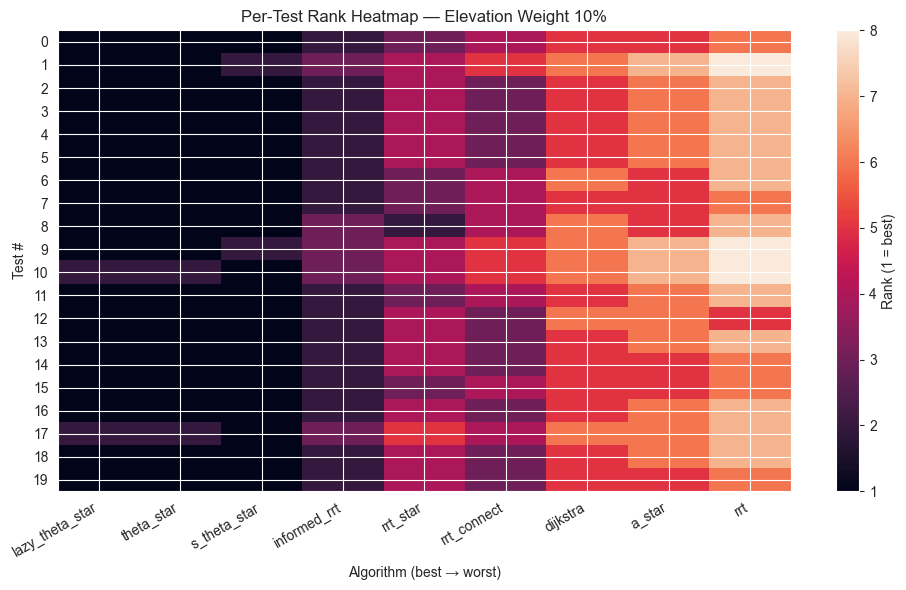

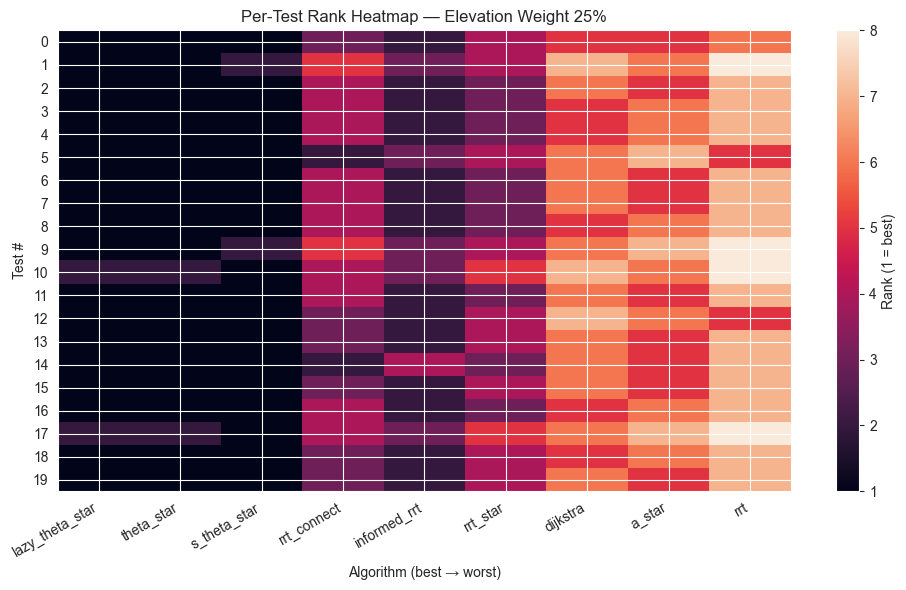

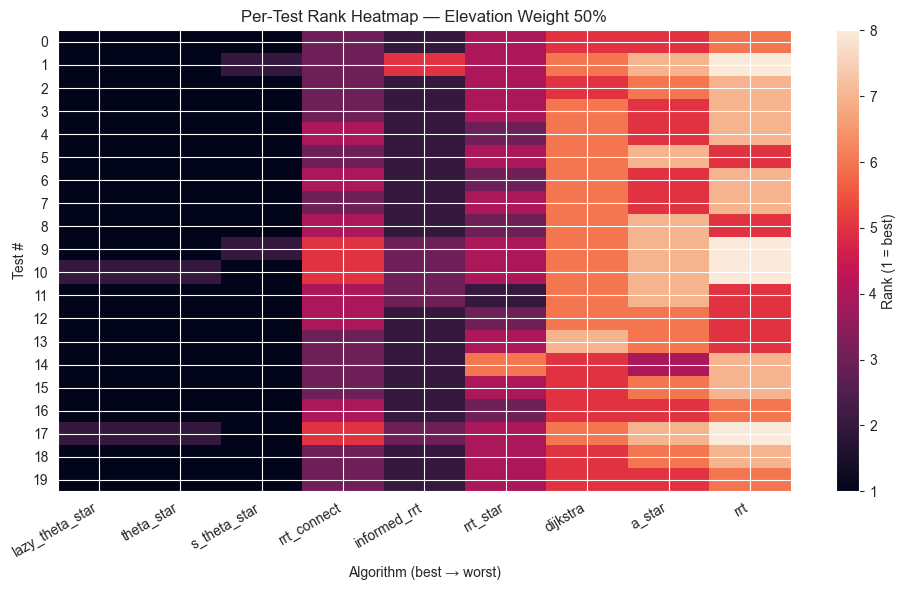

In [21]:
# TRE HEATMAPS (ett per elevation):
# y-akse = de 20 testene, x-akse = algoritmene (kolonner sortert best→dårligst for den elevationen)


def plot_test_algo_rank_heatmaps(df):
    for pct in sorted(df["elevation_pct"].unique()):
        d = df[df["elevation_pct"] == pct]
        mat = d.pivot(index="test", columns="algorithm", values="path_length").sort_index()

        # Kolonnerekkefølge: best → dårligst etter median path_length for denne elevationen
        order = mat.median(axis=0).sort_values(ascending=True).index.tolist()
        mat = mat[order]

        # Rang per test (rad), 1 = kortest. Dense gjør 1,1,2 ved tie.
        R = mat.rank(axis=1, method="dense", ascending=True)

        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        im = ax.imshow(R.values, aspect="auto", interpolation="nearest")
        cbar = plt.colorbar(im, ax=ax, label="Rank (1 = best)")

        ax.set_yticks(np.arange(len(R.index)))
        ax.set_yticklabels(R.index)           # test-IDer på y-aksen
        ax.set_xticks(np.arange(len(R.columns)))
        ax.set_xticklabels(R.columns, rotation=30, ha="right")  # algoritmer på x-aksen

        ax.set_xlabel("Algorithm (best → worst)")
        ax.set_ylabel("Test #")
        ax.set_title(f"Per-Test Rank Heatmap — Elevation Weight {pct}%")
        plt.tight_layout()
        plt.show()

plot_test_algo_rank_heatmaps(df)


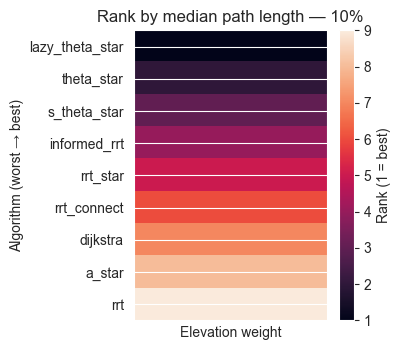

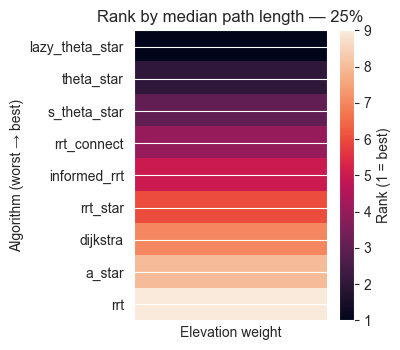

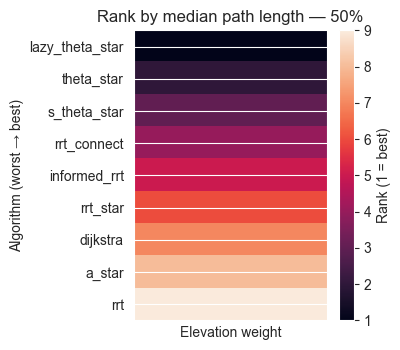

In [18]:
# TRE ENKLE HEATMAPS (ett per elevation): rank 1–12 basert på median path_length (lavest = best)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_rank_heatmaps(df):
    for pct in sorted(df["elevation_pct"].unique()):
        d = df[df["elevation_pct"] == pct]
        med = d.groupby("algorithm")["path_length"].median().sort_values(ascending=True)
        rank_vals = pd.Series(range(1, len(med)+1), index=med.index, name="rank")

        # Lag 1-kolonne heatmap med rank-verdier, sortert best→dårligst
        H = rank_vals.values.reshape(-1, 1)
        fig, ax = plt.subplots(figsize=(4, max(3, len(rank_vals)*0.4)))
        im = ax.imshow(H, aspect="auto", interpolation="nearest")
        plt.colorbar(im, ax=ax, label="Rank (1 = best)")

        ax.set_yticks(np.arange(len(rank_vals)))
        ax.set_yticklabels(rank_vals.index)
        ax.set_xticks([])
        #ax.set_xticklabels([f"{pct}%"])
        ax.set_xlabel("Elevation weight")
        ax.set_ylabel("Algorithm (worst → best)")
        ax.set_title(f"Rank by median path length — {pct}%")

        # Skriv rank-tallet i cellen
        #for i in range(len(rank_vals)):

        #    ax.text(0, i, str(int(rank_vals.iloc[i])), ha="center", va="center", fontsize=9)

        plt.tight_layout()
        plt.show()

plot_rank_heatmaps(df)


In [9]:
import numpy as np

TOL = dict(rtol=1e-9, atol=1e-9)

def augment_for_pct(df, pct):
    d = df[df["elevation_pct"] == pct].copy()
    d["_min"] = d.groupby("test")["path_length"].transform("min")
    d["_regret"] = (d["path_length"] - d["_min"]) / d["_min"]  # 0 = best (evt. delt)
    return d

def order_algs_for_weight(pct, summary_df=None):
    # Bruk 'summary' hvis tilgjengelig for sortering; ellers fallback til median path.
    if summary_df is not None and pct in summary_df.index.get_level_values(0):
        sub = summary_df.loc[pct]
        keys = [("wins", False), ("median", True), ("mean", True)]
        by   = [k for k,_ in keys if k in sub.columns]
        asc  = [a for k,a in keys if k in sub.columns]
        if by:
            return sub.sort_values(by=by, ascending=asc).index.tolist()
    # Fallback: sorter algoritmer etter lavest median path_length for denne elevationen
    d = df[df["elevation_pct"] == pct]
    med = d.groupby("algorithm")["path_length"].median().sort_values(ascending=True)
    return med.index.tolist()

C:\Users\NecoD\AppData\Local\Temp\ipykernel_26580\2573247464.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


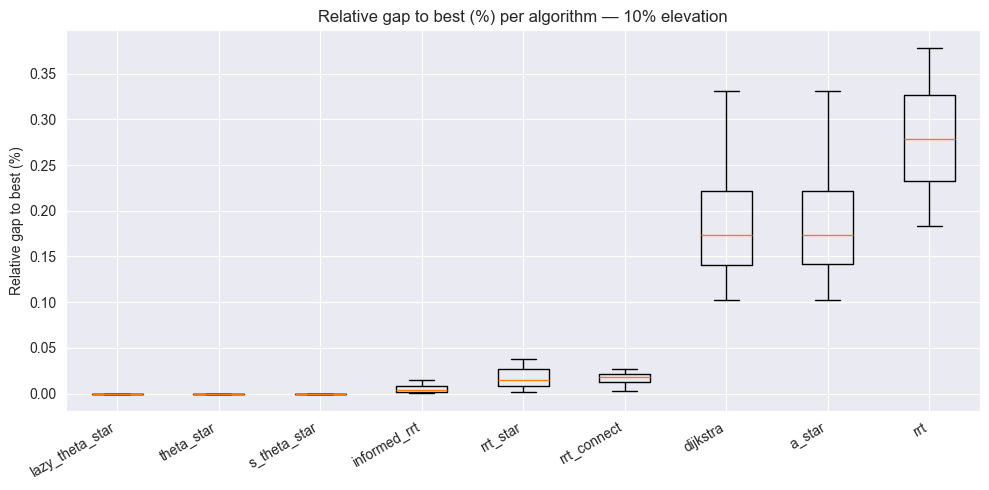

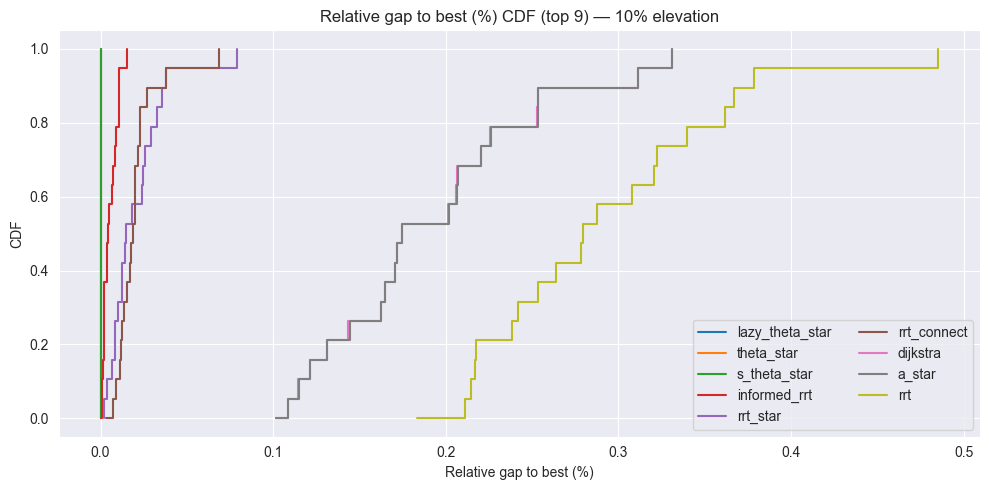

C:\Users\NecoD\AppData\Local\Temp\ipykernel_26580\2573247464.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


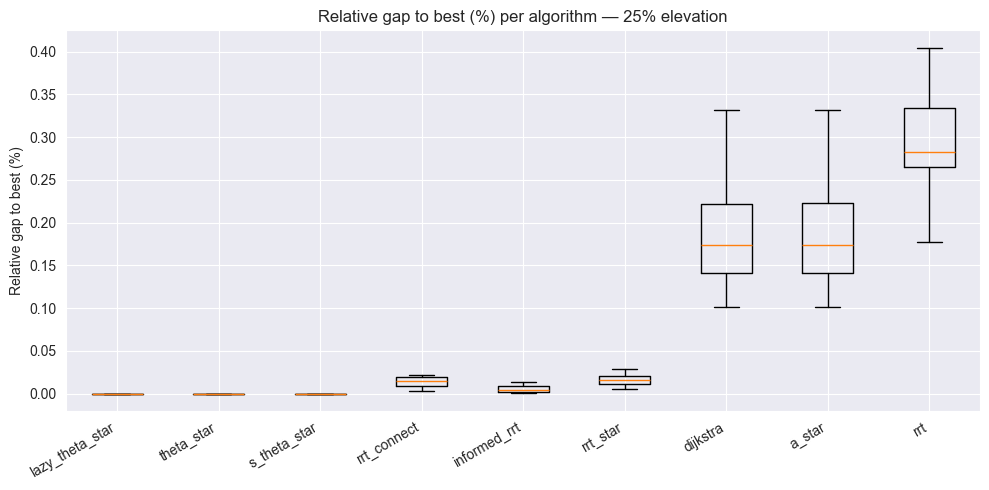

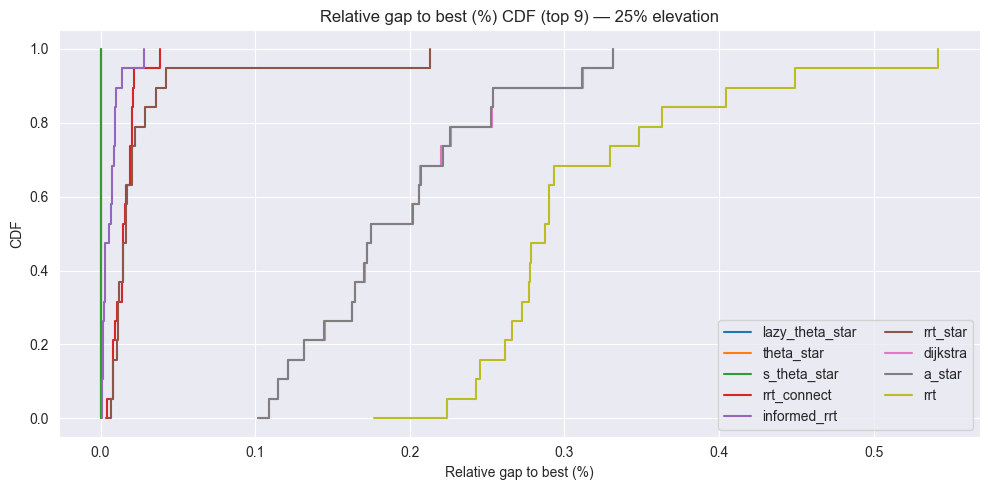

C:\Users\NecoD\AppData\Local\Temp\ipykernel_26580\2573247464.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


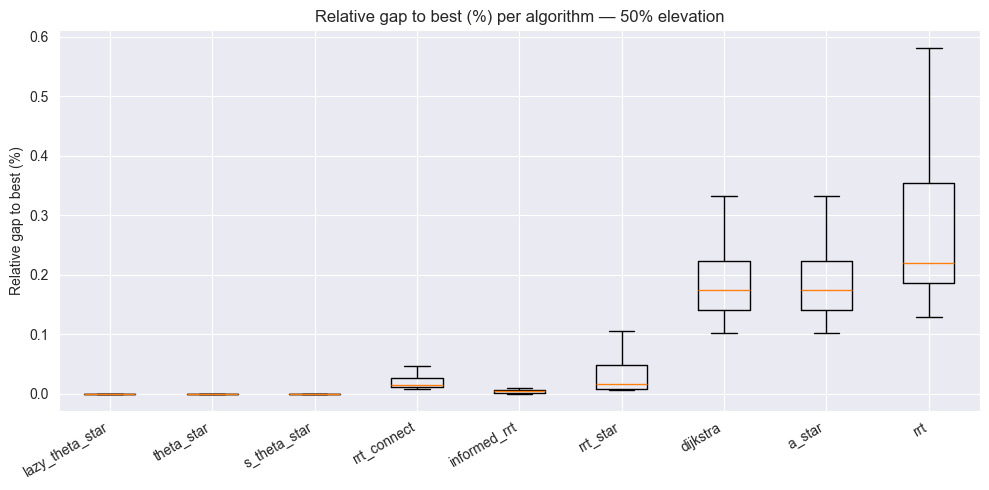

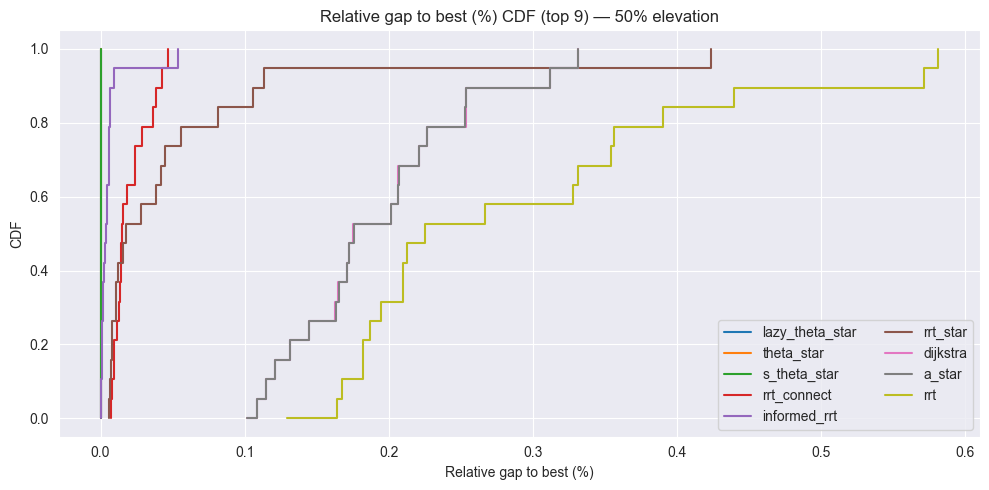

In [17]:
# REGRET / optimalitetsgap/ prosentavvik fra beste -ANALYSE (boxplot og enkel CDF for topp-K)

K = 9  # vis CDF for topp-K algoritmer (for oversikt)


for pct in sorted(df["elevation_pct"].unique()):
    d = augment_for_pct(df, pct)
    order = order_algs_for_weight(pct, summary)
    # Boxplot av regret
    data = [d.loc[d["algorithm"]==a, "_regret"].values for a in order]
    plt.figure(figsize=(10,5))
    plt.boxplot(data, labels=order, showfliers=False)
    plt.ylabel("Relative gap to best (%)")
    plt.title(f"Relative gap to best (%) per algorithm — {pct}% elevation")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout(); plt.show()

    # CDF for topp-K algoritmer (lavere er bedre)
    plt.figure(figsize=(10,5))
    for a in order[:K]:
        r = np.sort(d.loc[d["algorithm"]==a, "_regret"].values)
        y = np.linspace(0, 1, len(r), endpoint=True)
        plt.step(r, y, where="post", label=a)
    plt.xlabel("Relative gap to best (%)"); plt.ylabel("CDF")
    plt.title(f"Relative gap to best (%) CDF (top {K}) — {pct}% elevation")
    plt.legend(loc="lower right", ncol=2)
    plt.tight_layout(); plt.show()


###
regret måler hvor mye lengre ruten til en algoritme er enn den beste ruten i samme test, relativt til den beste.

For hver test t finner vi best = korteste path_length blant alle algoritmer.

For en gitt algoritme A i den testen:
regret(A, t) = (path_A − best) / best

Tolkning:

0.00 = A var best (eller delte 1.-plass).

0.01 = A var 1% lengre enn beste rute.

0.05 = 5% lengre, osv.
Lavere er bedre. 0 betyr “på topp”.


Du får 20 regret-verdier per algoritme (én per test). Boksplottet oppsummerer dem:

Median (streken i boksen): typisk ytelse. Nær 0 ⇒ ofte best/tilnærmet best.

IQR (boksen): stabilitet. Smal boks ⇒ jevn ytelse.

Whiskers/outliers: hvor ille det kan bli. Høy øvre whisker ⇒ enkelte tester der algoritmen var merkbart dårligere.

tolkning: En algoritme med median ~0 og veldig smal boks er nær “alltid best”. En som har median 3–5% og bred boks er ofte svakere og mer variabel.

For hver algoritme tegner CDF-en andelen tester med regret ≤ x.

På x-aksen velger du en toleranse (f.eks. 1%).

Y-verdien er da: “i hvor stor andel av testene var algoritmen innen 1% av best?”

Kurver som stiger tidlig/nært x=0 er best (mye masse helt ved 0 = mange delte 1.-plasser).

Høyden akkurat ved x=0 tilsvarer andel delt 1.-plass (matches wins_tie/20).

Om flere algoritmer har identisk regret-profil (typisk masse 0), vil kurvene ligge oppå hverandre noe som er grunnen til at man ser færre linjer.

nyttig fordi:

Rene seire (wins) forteller bare hvem som er #1; regret forteller hvor mye de andre taper med.


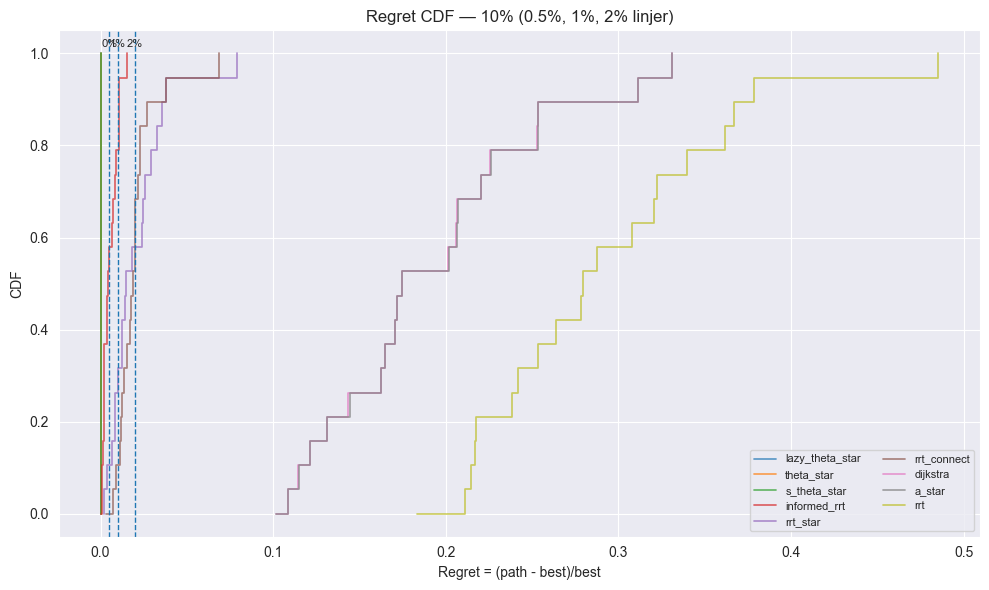

,=0%,≤0.5%,≤1%,≤2%
algorithm,,,,
lazy_theta_star,90.0,100.0,100.0,100.0
theta_star,90.0,100.0,100.0,100.0
s_theta_star,90.0,100.0,100.0,100.0
informed_rrt,0.0,60.0,80.0,100.0
rrt_star,0.0,15.0,30.0,60.0
rrt_connect,0.0,5.0,15.0,60.0
dijkstra,0.0,0.0,0.0,0.0
a_star,0.0,0.0,0.0,0.0
rrt,0.0,0.0,0.0,0.0


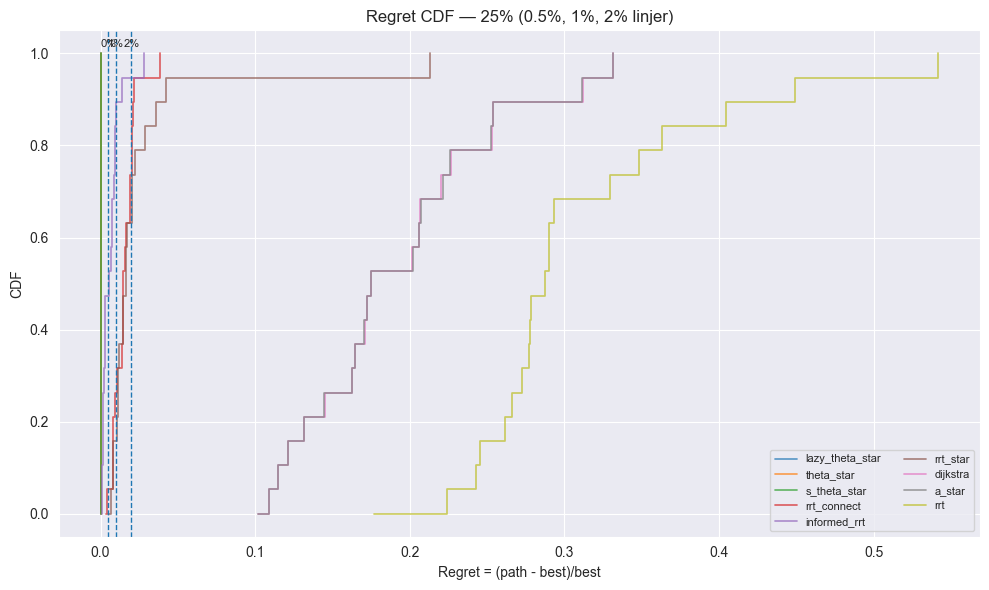

,=0%,≤0.5%,≤1%,≤2%
algorithm,,,,
lazy_theta_star,90.0,100.0,100.0,100.0
theta_star,90.0,100.0,100.0,100.0
s_theta_star,90.0,100.0,100.0,100.0
rrt_connect,0.0,10.0,30.0,75.0
informed_rrt,0.0,50.0,85.0,95.0
rrt_star,0.0,0.0,20.0,65.0
dijkstra,0.0,0.0,0.0,0.0
a_star,0.0,0.0,0.0,0.0
rrt,0.0,0.0,0.0,0.0


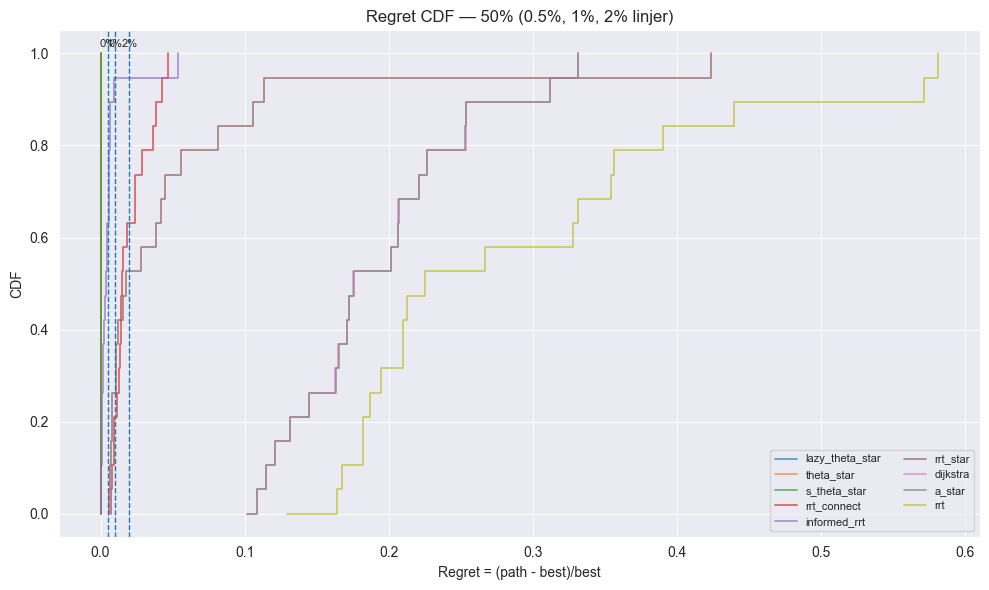

,=0%,≤0.5%,≤1%,≤2%
algorithm,,,,
lazy_theta_star,90.0,100.0,100.0,100.0
theta_star,90.0,100.0,100.0,100.0
s_theta_star,90.0,100.0,100.0,100.0
rrt_connect,0.0,0.0,25.0,65.0
informed_rrt,0.0,65.0,95.0,95.0
rrt_star,0.0,0.0,30.0,55.0
dijkstra,0.0,0.0,0.0,0.0
a_star,0.0,0.0,0.0,0.0
rrt,0.0,0.0,0.0,0.0


In [11]:
# CDF med ALLE algoritmer + vertikale terskler + nøkkeltabell per elevation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

EPS_LIST = [0.005, 0.01, 0.02]  # 0.5%, 1%, 2%
TOL = dict(rtol=1e-9, atol=1e-9)
np.random.seed(1)

for pct in sorted(df["elevation_pct"].unique()):
    d = augment_for_pct(df, pct)
    order = order_algs_for_weight(pct, summary)

    # CDF-plot for alle algoritmer
    plt.figure(figsize=(10, 6))
    for a in order:
        r = np.sort(d.loc[d["algorithm"] == a, "_regret"].values)
        y = np.linspace(0, 1, len(r), endpoint=True)
        # liten mikrojitter for å synliggjøre identiske kurver (kun visuelt)
        r_plot = r + (np.arange(len(r)) * 1e-8)
        plt.step(r_plot, y, where="post", alpha=0.7, linewidth=1.25, label=a)

    # Vertikale terskler
    for eps in EPS_LIST:
        plt.axvline(eps, linestyle="--", linewidth=1)
        plt.text(eps, 1.01, f"{int(eps*100)}%", ha="center", va="bottom", fontsize=8)

    plt.xlabel("Regret = (path - best)/best")
    plt.ylabel("CDF")
    plt.title(f"Regret CDF — {pct}% (0.5%, 1%, 2% linjer)")
    plt.legend(loc="lower right", ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()

    # Nøkkeltall: andel tester innen terskler
    rows = []
    for a in order:
        r = d.loc[d["algorithm"] == a, "_regret"].values
        pct_eq0   = (np.isclose(r, 0.0, **TOL)).mean() * 100   # delt 1.-plass
        pct_le05  = (r <= 0.005).mean() * 100
        pct_le1   = (r <= 0.01).mean() * 100
        pct_le2   = (r <= 0.02).mean() * 100
        rows.append([a, pct_eq0, pct_le05, pct_le1, pct_le2])

    tbl = (pd.DataFrame(rows, columns=["algorithm", "=0%", "≤0.5%", "≤1%", "≤2%"])
             .set_index("algorithm")
             .loc[order])
    display(tbl.round(1))


###

Kort tolkning av tabellen (for én elevation-prosent):

“=0%”: andel tester der algoritmen var best (regret = 0) – inkluderer delte 1.-plasser.
90% = 18 av 20 tester var den på 1. plass (ofte delt).

“≤0.5% / ≤1% / ≤2%”: andel tester der algoritmen lå innen X% av beste rute.
100% = alltid ≤ X% lengre enn best (altså praktisk talt like god).


s_theta_star / lazy_theta_star / theta_star:
=0% = 90% → de delte 1.-plassen i 18/20 tester. ≤0.5%/≤1%/≤2% = 100% → i alle tester var de ≤0.5% fra best.
Konklusjon: De tre er i praksis like gode og nesten alltid best.

informed_rrt:
=0% = 0% (aldri best), men ≤0.5% = 60%, ≤1% = 80%, ≤2% = 100%.
Konklusjon: Ofte nesten best (særlig innen 1–2%), selv om den sjelden vinner.

rrt_star / rrt_connect:
Lave “=0%”, men noen ganger innen 1–2% → av og til konkurransedyktige, men mer variable.

jps / lpa_star / gbfs / d_star_lite / dijkstra / rrt:
Nesten aldri nær best (svært lave prosenter).
Konklusjon: Svakere i dette oppsettet.


tolkning:

Tre algoritmer (s-/lazy-/theta) er (18/20) ganger best og alltid ≤0.5% fra best. En fjerde (informed_rrt) er sjelden best, men er ≤1% fra best i 80% av testene.

Oversett prosent til antall tester (×20) for klarhet.

,wins_unique,wins,p1,p2,p3,median_path,IQR_path,median_delta_pct
algorithm,,,,,,,,
s_theta_star,2,18,18,2,0,2677.597,828.860,0.000
lazy_theta_star,0,18,18,2,0,2676.963,828.634,0.000
theta_star,0,18,18,2,0,2676.963,828.634,0.000
informed_rrt,0,0,0,15,5,2702.851,839.448,0.409
rrt_star,0,0,0,1,5,2717.830,789.426,1.457
rrt_connect,0,0,0,0,10,2718.844,849.144,1.830
a_star,0,0,0,0,0,3280.158,1032.440,17.326
dijkstra,0,0,0,0,0,3279.359,1032.638,17.340
rrt,0,0,0,0,0,3503.653,999.890,27.873


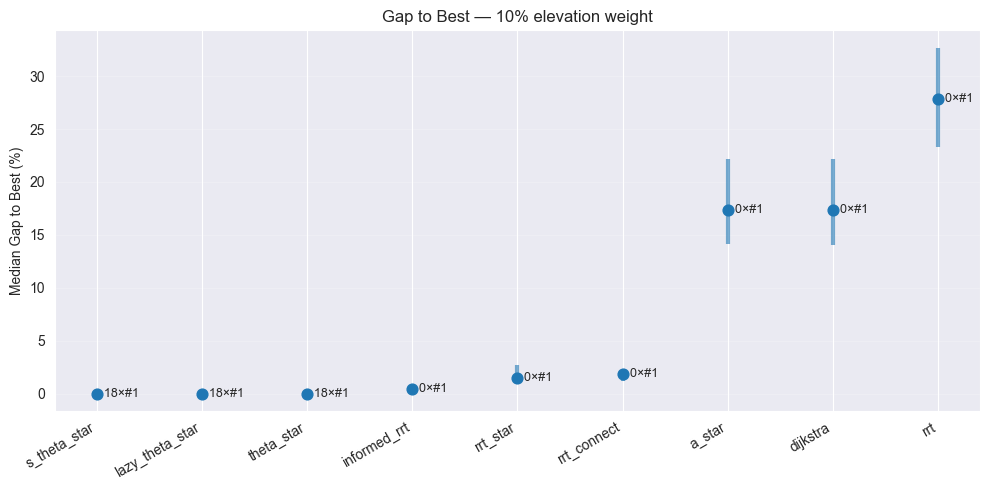

,wins_unique,wins,p1,p2,p3,median_path,IQR_path,median_delta_pct
algorithm,,,,,,,,
s_theta_star,2,18,18,2,0,2677.597,828.860,0.000
lazy_theta_star,0,18,18,2,0,2676.963,828.634,0.000
theta_star,0,18,18,2,0,2676.963,828.634,0.000
informed_rrt,0,0,0,14,5,2708.153,835.653,0.428
rrt_connect,0,0,0,2,6,2707.787,863.572,1.469
rrt_star,0,0,0,0,9,2730.070,826.284,1.552
a_star,0,0,0,0,0,3280.465,1031.648,17.359
dijkstra,0,0,0,0,0,3280.041,1032.777,17.360
rrt,0,0,0,0,0,3507.322,993.355,28.292


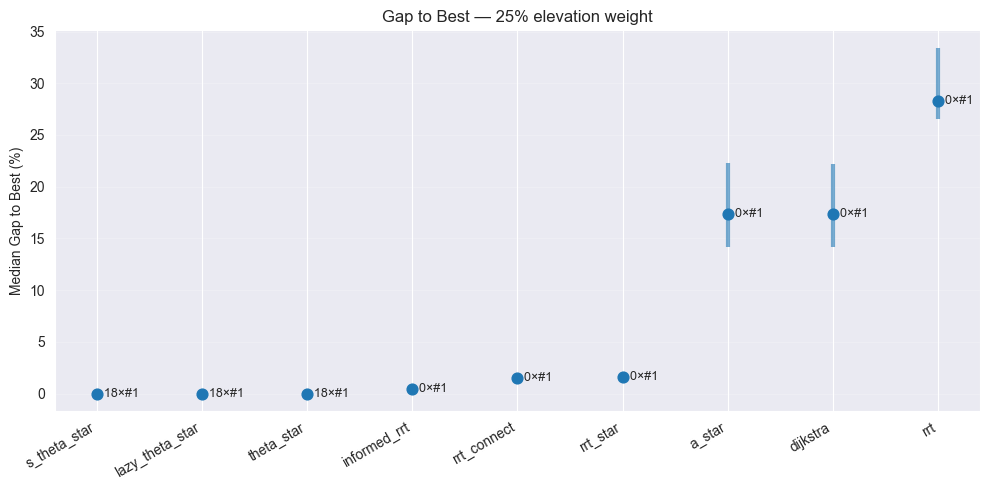

,wins_unique,wins,p1,p2,p3,median_path,IQR_path,median_delta_pct
algorithm,,,,,,,,
s_theta_star,2,18,18,2,0,2677.597,828.860,0.000
lazy_theta_star,0,18,18,2,0,2676.963,828.634,0.000
theta_star,0,18,18,2,0,2676.963,828.634,0.000
informed_rrt,0,0,0,15,4,2726.447,839.229,0.347
rrt_connect,0,0,0,0,11,2712.814,828.698,1.476
rrt_star,0,0,0,1,5,2905.829,965.308,1.662
dijkstra,0,0,0,0,0,3279.546,1032.645,17.378
a_star,0,0,0,0,0,3280.561,1032.395,17.396
rrt,0,0,0,0,0,3419.255,1069.892,21.891


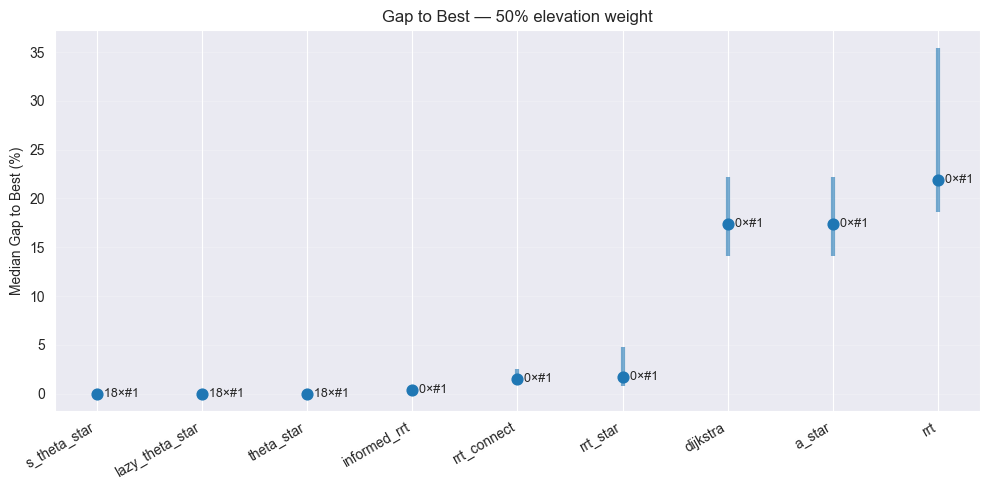

In [14]:
# Tie-robust sammendrag + lollipop-plot (bruker elevation_pct og håndterer uavgjort)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sammendrag per elevation (dense-rank m/ avrunding for å slå sammen like ruter)
def make_clean_summary_for_weight(df, pct, round_decimals=6):
    d = df[df["elevation_pct"] == pct].copy()

    # Beste per test og prosent-avvik fra best
    best = d.groupby("test")["path_length"].min().rename("best")
    d = d.merge(best, on="test")
    d["delta_pct"] = 100 * (d["path_length"] / d["best"] - 1.0)

    # Tie-robust rangering (dense) – rund litt for å samle identiske ruter
    d["path_q"] = d["path_length"].round(round_decimals)
    d = d.sort_values(["test", "path_q", "algorithm"])
    d["rank"] = d.groupby("test")["path_q"].rank(method="dense")


    winners = d[d["rank"] == 1].groupby("test")["algorithm"].transform("count")
    d.loc[d["rank"] == 1, "tie_size"] = winners
    d["tie_size"] = d["tie_size"].fillna(0)

    # Aggreger
    g_len = d.groupby("algorithm")["path_length"]
    g_del = d.groupby("algorithm")["delta_pct"]

    summary = pd.DataFrame({
        "median_path":     g_len.median(),
        "IQR_path":        g_len.quantile(0.75) - g_len.quantile(0.25),
        "median_delta_pct":g_del.median(),
        "q25_delta_pct":   g_del.quantile(0.25),
        "q75_delta_pct":   g_del.quantile(0.75),
    })

    # Seire (inkl. delt) og soleklare seire
    wins_tie = d[d["rank"] == 1].groupby("algorithm").size()
    wins_unique = d[(d["rank"] == 1) & (d["tie_size"] == 1)].groupby("algorithm").size()

    summary["wins"] = wins_tie.reindex(summary.index, fill_value=0).astype(int)
    summary["wins_unique"] = wins_unique.reindex(summary.index, fill_value=0).astype(int)

    # Pallen 1/2/3 (tie-aware via dense-rank)
    for r, name in [(1, "p1"), (2, "p2"), (3, "p3")]:
        summary[name] = d[d["rank"] == r].groupby("algorithm").size().reindex(summary.index, fill_value=0).astype(int)

    # Sortér: soleklare seire ↓, alle seire ↓, nærmest best (median_delta_pct) ↑, så kortest median_path ↑
    summary = summary.sort_values(
        by=["wins_unique", "wins", "median_delta_pct", "median_path"],
        ascending=[False, False, True, True]
    )
    return summary

# ---- Lollipop-plot av "hvor langt fra beste" (median med IQR, + antall #1) ----
def plot_lollipop(summary, pct, ylabel="Median Gap to Best (%)"):
    order = summary.index.tolist()
    y   = summary.loc[order, "median_delta_pct"].values
    ylo = summary.loc[order, "q25_delta_pct"].values
    yhi = summary.loc[order, "q75_delta_pct"].values
    wins = summary.loc[order, "wins"].astype(int).values
    wuniq = summary.loc[order, "wins_unique"].astype(int).values

    x = np.arange(len(order))
    plt.figure(figsize=(10, 5))
    # IQR som vertikale linjer
    plt.vlines(x, ylo, yhi, linewidth=3, alpha=0.6)
    # Lollipop-punkter (median)
    plt.scatter(x, y, s=60, zorder=3)
    # Annotér seire (#1 totals og soleklare)
    for xi, yi, wt in zip(x, y, wins):
        plt.text(xi, yi, f"  {wt}×#1", va="center", fontsize=9)

    plt.xticks(x, order, rotation=30, ha="right")
    plt.ylabel(ylabel)
    plt.title(f"Gap to Best — {pct}% elevation weight")
    plt.grid(axis="y", alpha=0.2)
    plt.tight_layout()
    plt.show()

for pct in sorted(df["elevation_pct"].unique()):
    summ = make_clean_summary_for_weight(df, pct, round_decimals=6)
    display(summ[["wins_unique","wins","p1","p2","p3","median_path","IQR_path","median_delta_pct"]].round(3))
    plot_lollipop(summ, pct)


###
Per elevation (her: 10%):

wins = antall tester der algoritmen var på 1. plass (inkl. delt 1. plass).
18 betyr 18 av 20 tester på topp (ofte delt).

wins_unique = antall tester der algoritmen vant alene (ingen delt 1. plass).

p1 / p2 / p3 = antall pallplasseringer med tie-håndtering (dense rank).
p1 er i praksis lik «wins», p2 er antall ganger den var på 2. plass (når ikke alle er delt 1.), p3 tilsvarende for 3. plass.

median_path = median distanse (absolutt antall meter/enheter).

IQR_path = spredning i distanse (Q75−Q25).

median_delta_pct = median prosent lenger enn beste rute i samme test. Lavere er bedre.
0.0 betyr «typisk like god som best»; 0.5 betyr 0.5 % lengre, osv.


figurene viser:
Punktet = median_delta_pct (median hvor mange % lenger enn best).

Vertikal strek = IQR i % (Q25–Q75): hvor stabil algoritmen er over testene.

Teksten “×#1” ved punktet = wins; hvis det står “(unik)”, er det wins_unique.

Tolkning av figure: Punkter nær 0 % og korte streker = ofte best og stabil (super bra).

Punkter høyere opp og lange streker = ofte lengre ruter og/eller mer variabelt.